Nice read on "How to set up Anaconda and Jupyter Notebook the right way": https://towardsdatascience.com/how-to-set-up-anaconda-and-jupyter-notebook-the-right-way-de3b7623ea4a

In [120]:
import json
import pandas as pd
import gzip

# Familiarize Yourself with the Dataset
In the lab sessions, we will work with the "All Beauty" category of the Amazon Review Data, and we will use the 5-core subset. You can download the dataset and find information about it here: https://nijianmo.github.io/amazon/index.html

## Exercise 1
Download and import the 5-core dataset.

In [121]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('All_Beauty_5.json.gz')

# If you unzip the folder manually, you may simply run the following command:
# df = pd.read_json("All_Beauty_5.json", lines=True)

## Exercise 2

### 2.1 
Sort the dataset entries (ascending) by user id (`reviewerID`), product id (`asin`) and rating timestamp (`unixReviewTime`). Then, check the dataset for missing ratings (`overall`) and duplicates (cases where the same user has rated the same item multiple times) and clean them, if any. For duplicates, keep the last entry only. How many observations does the cleaned dataset have?

In [122]:
def data_cleaning(df):
    
    # Write your code here

    # Sort by revierID, asin unixReviewTime
    df = df.sort_values(by=['reviewerID', 'asin', 'unixReviewTime'])

    # Drop rows with missing overall rating
    df = df.dropna(subset=['overall'])

    # Drop duplicates based on (reviewerID, asin), keeping only the last row
    df_cleaned = df.drop_duplicates(subset=['reviewerID', 'asin'], keep='last')

    print(df_cleaned.shape)

    return df_cleaned

df = data_cleaning(df)

(4092, 12)


### 2.2
Create a test set by extracting the *single* **latest** (based on the timestamp `unixReviewTime`) positively rated item (rating $\geq 4$) by each user. Remove users that do not appear in the training set. How many observations does the training and test set have?

Note: After the test set is extracted, the *cleaned* dataset is now the trainset. (i.e., the trainset is completely separate from the test set, not a superset of it)

In [123]:
def data_split(df):

    # Keep only positively rated items
    df_positive = df[df['overall']>=4]

    # Sorting to be sure that the last is actually the latest review by the user
    df_positive = df_positive.sort_values(by=['reviewerID', 'unixReviewTime'])

    # For each user, keep only the last (most recent) positively rated item
    test = df_positive.drop_duplicates(subset=['reviewerID'], keep='last')

    # Build your training set by removing these test rows
    training = df.drop(test.index)

    # Remove users from the test set who don’t appear in the training set
    train_users = training['reviewerID'].unique()
    test = test[test['reviewerID'].isin(train_users)]
    
    return training, test

In [124]:
df_train, df_test = data_split(df)

print("Observations in training set:", len(df_train))
print("Observations in test set:", len(df_test))

Observations in training set: 3133
Observations in test set: 949


## Exercise 3

Compute the number of ratings per item in the training set. How does a barplot of the number of ratings per item ordered by decreasing frequency look like?

Reflect on how it will affect the prediction process of a recommender system if only a small fraction of the items are rated frequently.

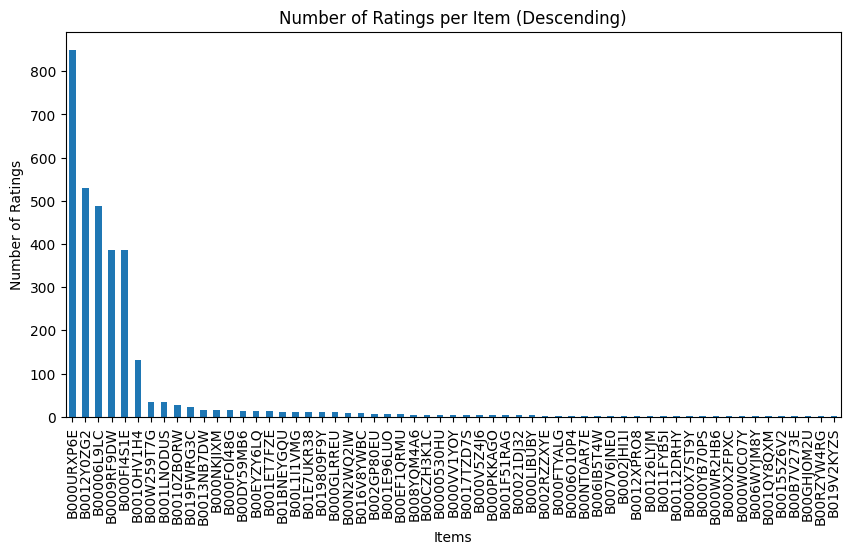

In [125]:
import matplotlib.pyplot as plt 

item_counts = df_train.groupby("asin")['overall'].count().sort_values(ascending=False)
item_counts.plot(kind='bar', figsize=(10, 5))
plt.xlabel("Items")
plt.ylabel("Number of Ratings")
plt.title("Number of Ratings per Item (Descending)")

plt.show()

# Collaborative Filtering Recommender System

## Exercise 1
In this exercise, we are going to predict the rating of a single user-item pair using a neighborhood-based method.

### 1.1
- Represent the ratings from the training set in a user-item matrix where the rows represent users and the columns represent items.
- Fill unobserved ratings with $0$.
- Compute the cosine similarities between the user with `reviewerID`='A25C2M3QF9G7OQ' and all users that have rated the item with `asin`='B00EYZY6LQ'.
- What are the similarities and what are the ratings given by these users on item 'B00EYZY6LQ'?

In [126]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [127]:
# Loading and preparing data
user_item_matrix = df_train.pivot_table(index='reviewerID',columns='asin',values='overall')
user_item_matrix = user_item_matrix.fillna(0)
target_user = user_item_matrix.loc[['A25C2M3QF9G7OQ']]
input_users = user_item_matrix[user_item_matrix['B00EYZY6LQ']>0]
users = pd.concat([target_user, input_users])

# Write your code here to compute cosine similarity and report results

print(input_users.shape)

print(target_user.shape)
# Compute the cosine similarities between the user with reviewerID=‘A25C2M3QF9G7OQ’ and all users that have rated the item with asin=‘B00EYZY6LQ’.
cosine_sim = cosine_similarity(target_user, input_users)

print(cosine_sim.shape)

print(cosine_sim)

item = 'B00EYZY6LQ'

# What are the similarities and what are the ratings given by these users on item ‘B00EYZY6LQ’?
target_item = pd.DataFrame(cosine_sim[0], index=input_users.index, columns=['similarity'])
target_item['overall'] = input_users[item]
table = target_item
print(table)

(13, 59)
(1, 59)
(1, 13)
[[0.07924289 0.24514517 0.05863363 0.20788269 0.27580986 0.
  0.         0.68283473 0.         0.         0.         0.24514517
  0.10567049]]
                similarity  overall
reviewerID                         
A1F7YU6O5RU432    0.079243      5.0
A1R1BFJCMWX0Y3    0.245145      3.0
A1UQBFCERIP7VJ    0.058634      5.0
A22CW0ZHY3NJH8    0.207883      3.0
A2LW5AL0KQ9P1M    0.275810      4.0
A2PD27UKAD3Q00    0.000000      5.0
A2WW57XX2UVLM6    0.000000      4.0
A2ZY49IDE6TY5I    0.682835      4.0
A39WWMBA0299ZF    0.000000      5.0
A3M6TSEV71537G    0.000000      5.0
A3S3R88HA0HZG3    0.000000      4.0
A914TQVHI872U     0.245145      5.0
AOEUN9718KVRD     0.105670      3.0


### 1.2
Predict the rating for user 'A25C2M3QF9G7OQ' on item 'B00EYZY6LQ' based on the ratings from the $5$ most similar users, using a weighted (by cosine similarity) average. You do not need to account for the mean rating per user for the weighted average. What is the prediction? Round the predicted rating to 3 decimal places.

In [128]:
k = 5
target_item_k = target_item.sort_values(by='similarity', 
                                        ascending=False)[:k]

prediction_KNN = np.dot(target_item_k['similarity'], target_item_k['overall']) / target_item_k['similarity'].sum()

print('Predicted rating:', prediction_KNN)

Predicted rating: 3.8745289248148613


In [129]:
### Recommended: Save the dataframe to load them in the next Session

df_train.to_pickle("train_dataframe.pkl")
df_test.to_pickle("test_dataframe.pkl")